In [2]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt

In [3]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [4]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm
import cv2
sns.set_style('darkgrid')

In [5]:
train_dir="D:\\IEEEModel\\Train"
test_dir="D:\\IEEEModel\\Test"

In [6]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
      
        for filename in os.listdir(directory+"/"+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

In [7]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
train.head()

,image,label
0,D:\IEEEModel\Train\Eco\2022012615084019-dry-as...,Eco
1,D:\IEEEModel\Train\Eco\2022012615204711-dry-as...,Eco
2,D:\IEEEModel\Train\Eco\2022012619360610-water-...,Eco
3,D:\IEEEModel\Train\Eco\2022012621281716-dry-co...,Eco
4,D:\IEEEModel\Train\Eco\2022012621281717-dry-co...,Eco


In [8]:
## convert into dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_dir)
test.head()

,image,label
0,D:\IEEEModel\Test\Eco\202201260012527-dry-asph...,Eco
1,D:\IEEEModel\Test\Eco\202201260012528-dry-asph...,Eco
2,D:\IEEEModel\Test\Eco\202201260012529-dry-asph...,Eco
3,D:\IEEEModel\Test\Eco\202201261342122-dry-asph...,Eco
4,D:\IEEEModel\Test\Eco\202201261454135-dry-asph...,Eco


In [9]:
train.columns

Index(['image', 'label'], dtype='object')

In [10]:
train

,image,label
0,D:\IEEEModel\Train\Eco\2022012615084019-dry-as...,Eco
1,D:\IEEEModel\Train\Eco\2022012615204711-dry-as...,Eco
2,D:\IEEEModel\Train\Eco\2022012619360610-water-...,Eco
3,D:\IEEEModel\Train\Eco\2022012621281716-dry-co...,Eco
4,D:\IEEEModel\Train\Eco\2022012621281717-dry-co...,Eco
...,...,...
80218,D:\IEEEModel\Train\Sports\347.jpg,Sports
80219,D:\IEEEModel\Train\Sports\348.jpg,Sports
80220,D:\IEEEModel\Train\Sports\350.jpg,Sports
80221,D:\IEEEModel\Train\Sports\351.jpg,Sports


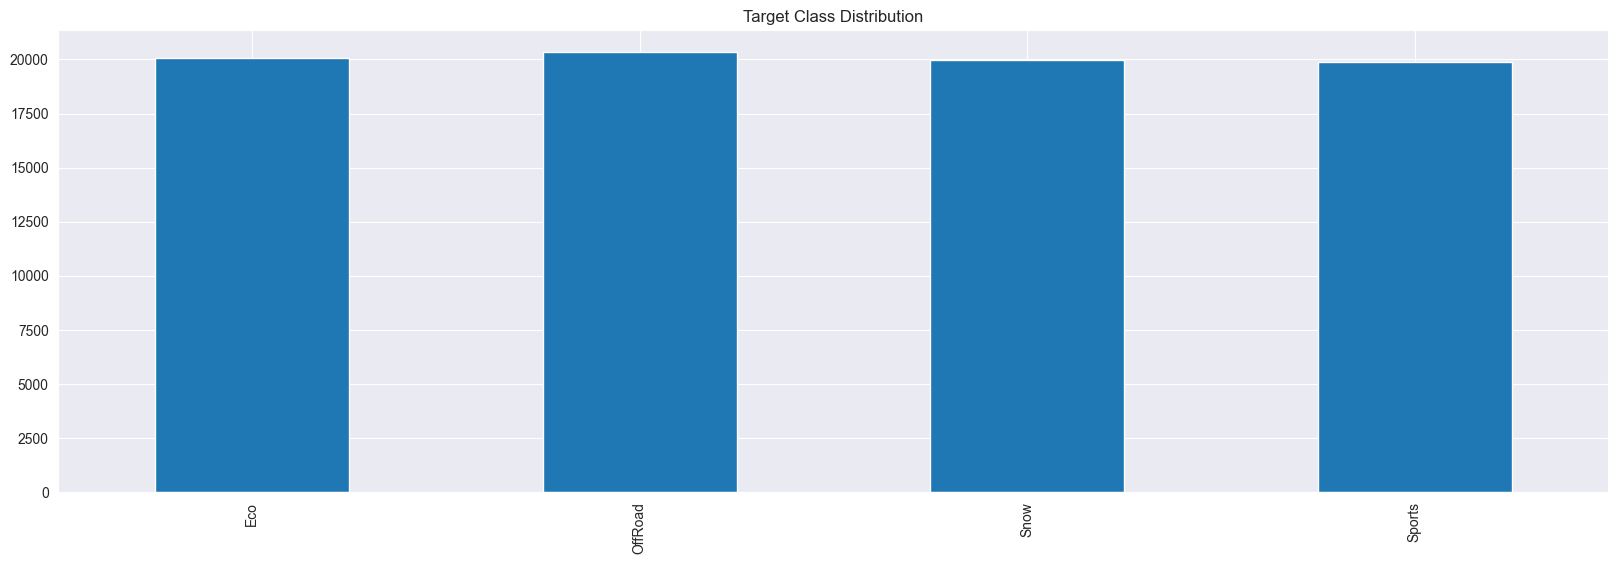

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer().fit(train.label.apply(lambda x: x.split()))
labels = pd.DataFrame(mlb.transform(train.label.apply(lambda x: x.split())), columns=mlb.classes_)

fig, ax = plt.subplots(figsize=(20, 6))
labels.sum().plot.bar(title='Target Class Distribution');

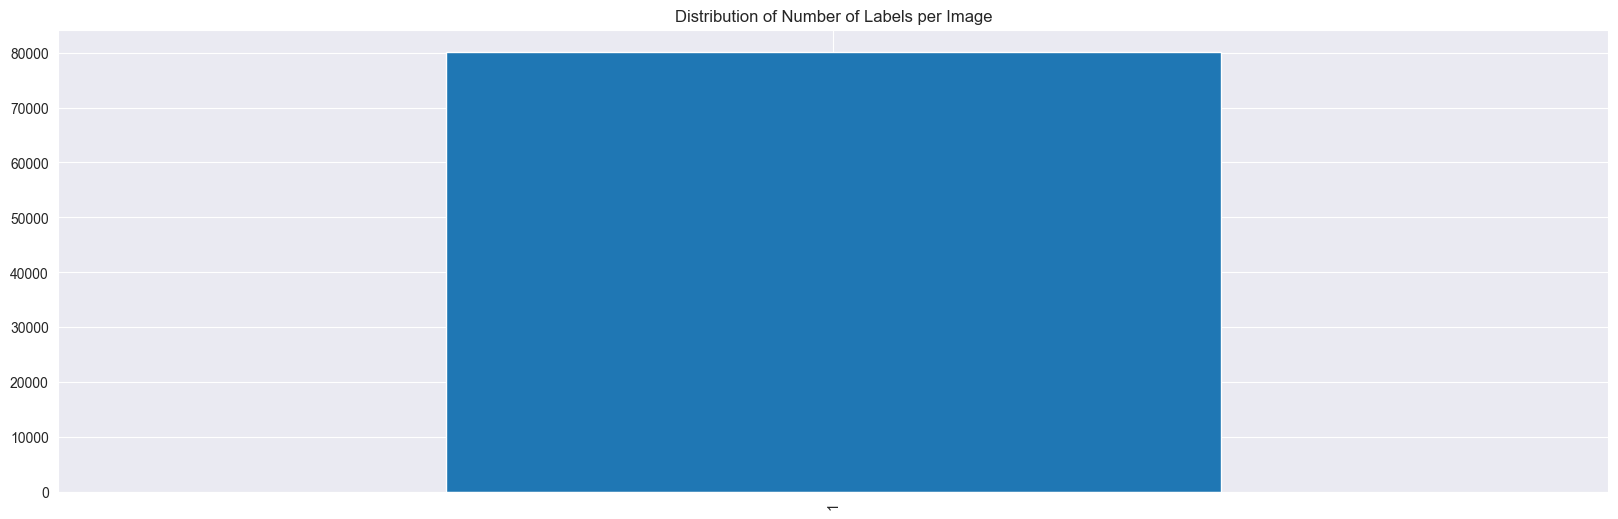

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
labels.sum(axis=1).value_counts().plot.bar(title='Distribution of Number of Labels per Image');

In [13]:
labels = pd.concat([train['image'], labels], axis=1) #.drop('healthy', axis=1)
labels.head()

,image,Eco,OffRoad,Snow,Sports
0,D:\IEEEModel\Train\Eco\2022012615084019-dry-as...,1,0,0,0
1,D:\IEEEModel\Train\Eco\2022012615204711-dry-as...,1,0,0,0
2,D:\IEEEModel\Train\Eco\2022012619360610-water-...,1,0,0,0
3,D:\IEEEModel\Train\Eco\2022012621281716-dry-co...,1,0,0,0
4,D:\IEEEModel\Train\Eco\2022012621281717-dry-co...,1,0,0,0


In [14]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_dir,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_dir,transform=transformer),
    batch_size=32, shuffle=True
)

In [15]:
#categories
root=pathlib.Path(train_dir)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [16]:
print(classes)

['Eco', 'OffRoad', 'Snow', 'Sports']


In [17]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
            
        


In [18]:
torch.cuda.is_available()

True

In [19]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
print(device)

cuda


In [21]:
model=ConvNet(num_classes=4).to(device)

In [22]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [23]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_dir+'/**/*.jpg'))
test_count=len(glob.glob(test_dir+'/**/*.jpg'))

In [24]:
print(train_count,test_count)

80223 17205


In [25]:
num_epochs=10

In [26]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    test_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        test_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=train_loss/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy)+' Test Loss: '+str(test_loss))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'PyTorchMode_NewCompressed2.model')
        best_accuracy=test_accuracy
    
       


Epoch: 0 Train Loss: tensor(3.1426) Train Accuracy: 0.6360270745297484 Test Accuracy: 0.5402499273467015 Test Loss: tensor(0.0002)
Epoch: 1 Train Loss: tensor(0.5745) Train Accuracy: 0.7821073756902633 Test Accuracy: 0.5251380412670735 Test Loss: tensor(3.3390e-05)
Epoch: 2 Train Loss: tensor(0.4551) Train Accuracy: 0.8244393752415142 Test Accuracy: 0.46399302528334785 Test Loss: tensor(2.6454e-05)
Epoch: 3 Train Loss: tensor(0.4088) Train Accuracy: 0.8457549580544232 Test Accuracy: 0.6753850624818367 Test Loss: tensor(2.3762e-05)
Epoch: 4 Train Loss: tensor(0.3636) Train Accuracy: 0.8630567293668898 Test Accuracy: 0.6752688172043011 Test Loss: tensor(2.1136e-05)
Epoch: 5 Train Loss: tensor(0.3289) Train Accuracy: 0.8758585443077421 Test Accuracy: 0.5635571054925894 Test Loss: tensor(1.9118e-05)
Epoch: 6 Train Loss: tensor(0.3002) Train Accuracy: 0.888149283871209 Test Accuracy: 0.6408020924149956 Test Loss: tensor(1.7448e-05)
Epoch: 7 Train Loss: tensor(0.2789) Train Accuracy: 0.89925